# Homework 2 — Task 3: Model Comparison (Decision Tree vs Bagging vs Boosting)





## 0. Imports & setup

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, f1_score
import matplotlib.pyplot as plt

try:
    from scipy.stats import ttest_rel
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 1. Load data


In [ ]:

!wget -q -O bank_marketing.zip https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
!unzip -o bank_marketing.zip -d . > /dev/null
!unzip -o bank.zip > /dev/null

df = pd.read_csv("bank-full.csv", sep=";")
print("Shape:", df.shape)
df.head()


Shape: (45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## 2. Preprocess (one-hot encode categoricals, passthrough numerics)

In [ ]:
target_col = "y"
y = (df[target_col].astype(str).str.lower() == "yes").astype(int)
X = df.drop(columns=[target_col]).copy()

cat_cols = [c for c in X.columns if X[c].dtype == "object"]
num_cols = [c for c in X.columns if c not in cat_cols]

X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# Keep sparse one-hot to avoid huge dense matrices
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

print("Train size:", X_train.shape, "Holdout size:", X_holdout.shape)


Train size: (36168, 16) Holdout size: (9043, 16)


## 3. Define the three models


In [ ]:
# Decision Tree (single model)
tree_pipe = Pipeline([
    ("prep", preprocess),
    ("model", DecisionTreeClassifier(max_depth=6, min_samples_leaf=20, random_state=RANDOM_STATE))
])

# Bagging — Random Forest
rf_pipe = Pipeline([
    ("prep", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=150, min_samples_leaf=10, random_state=RANDOM_STATE, n_jobs=-1
    ))
])

# Boosting — AdaBoost (stumps)
ada_pipe = Pipeline([
    ("prep", preprocess),
    ("model", AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1, random_state=RANDOM_STATE),
        n_estimators=150, learning_rate=0.5, random_state=RANDOM_STATE
    ))
])

models = {
    "Decision Tree": tree_pipe,
    "Random Forest (Bagging)": rf_pipe,
    "AdaBoost (Boosting)": ada_pipe,
}
models


{'Decision Tree': Pipeline(steps=[('prep',
                  ColumnTransformer(transformers=[('cat',
                                                   OneHotEncoder(handle_unknown='ignore'),
                                                   ['job', 'marital',
                                                    'education', 'default',
                                                    'housing', 'loan', 'contact',
                                                    'month', 'poutcome']),
                                                  ('num', 'passthrough',
                                                   ['age', 'balance', 'day',
                                                    'duration', 'campaign',
                                                    'pdays', 'previous'])])),
                 ('model',
                  DecisionTreeClassifier(max_depth=6, min_samples_leaf=20,
                                         random_state=42))]),
 'Random Forest (Bagging)': Pipeline(

## 4. Confusion matrix for one selected test fold



In [ ]:
# Pick CV scheme and a single fold to visualize
k_for_confusion = 10
selected_fold_index = 0

cv = StratifiedKFold(n_splits=k_for_confusion, shuffle=True, random_state=RANDOM_STATE)
splits = list(cv.split(X_train, y_train))

train_idx, test_idx = splits[selected_fold_index]
X_fold_train, y_fold_train = X_train.iloc[train_idx], y_train.iloc[train_idx]
X_fold_test, y_fold_test = X_train.iloc[test_idx], y_train.iloc[test_idx]

print(f"Using k={k_for_confusion}, selected fold={selected_fold_index}")
print("Fold train size:", X_fold_train.shape, "Fold test size:", X_fold_test.shape)


Using k=10, selected fold=0
Fold train size: (32551, 16) Fold test size: (3617, 16)


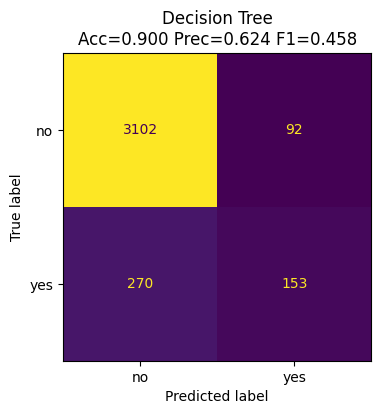

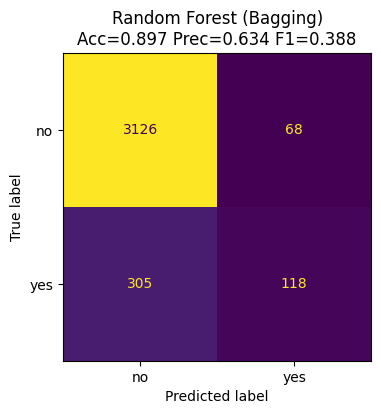

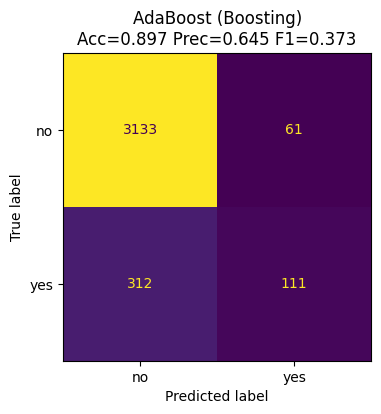

,model,accuracy,precision,f1,TN,FP,FN,TP
0,Decision Tree,0.899917,0.624490,0.458084,3102,92,270,153
1,Random Forest (Bagging),0.896876,0.634409,0.387521,3126,68,305,118
2,AdaBoost (Boosting),0.896876,0.645349,0.373109,3133,61,312,111


In [ ]:
def eval_and_plot_confusion(name, pipe, Xtr, ytr, Xte, yte):
    pipe.fit(Xtr, ytr)
    pred = pipe.predict(Xte)

    cm = confusion_matrix(yte, pred, labels=[0,1])
    acc = accuracy_score(yte, pred)
    prec = precision_score(yte, pred, zero_division=0)
    f1 = f1_score(yte, pred, zero_division=0)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["no", "yes"])
    fig, ax = plt.subplots(figsize=(4.5, 4))
    disp.plot(ax=ax, values_format="d", colorbar=False)
    plt.title(f"{name}\nAcc={acc:.3f} Prec={prec:.3f} F1={f1:.3f}")
    plt.show()

    return {"model": name, "accuracy": acc, "precision": prec, "f1": f1, "TN": cm[0,0], "FP": cm[0,1], "FN": cm[1,0], "TP": cm[1,1]}

fold_rows = []
for name, pipe in models.items():
    fold_rows.append(eval_and_plot_confusion(name, pipe, X_fold_train, y_fold_train, X_fold_test, y_fold_test))

pd.DataFrame(fold_rows)


## 5. Statistical test: paired t-test across folds

We compute a per-fold metric for each model (same folds) and run paired t-tests to check whether differences are statistically significant.

**Metric for significance test:** F1-score


In [ ]:
def per_fold_scores(pipe, X, y, cv, metric="f1"):
    scores = []
    for tr, te in cv.split(X, y):
        Xtr, Xte = X.iloc[tr], X.iloc[te]
        ytr, yte = y.iloc[tr], y.iloc[te]
        pipe.fit(Xtr, ytr)
        pred = pipe.predict(Xte)

        if metric == "accuracy":
            s = accuracy_score(yte, pred)
        elif metric == "precision":
            s = precision_score(yte, pred, zero_division=0)
        else:
            s = f1_score(yte, pred, zero_division=0)
        scores.append(s)
    return np.array(scores, dtype=float)

metric_for_test = "f1"
k_for_test = 15
cv_test = StratifiedKFold(n_splits=k_for_test, shuffle=True, random_state=RANDOM_STATE)

scores = {}
for name, pipe in models.items():
    scores[name] = per_fold_scores(pipe, X_train, y_train, cv_test, metric=metric_for_test)

pd.DataFrame({k: v for k, v in scores.items()})


,Decision Tree,Random Forest (Bagging),AdaBoost (Boosting)
0,0.431461,0.370732,0.370000
1,0.469248,0.350133,0.360313
2,0.468354,0.436019,0.383178
3,0.476793,0.397985,0.370558
4,0.515337,0.411911,0.415648
5,0.492632,0.397985,0.351485
6,0.399061,0.360313,0.399002
7,0.411348,0.410000,0.367347
8,0.472648,0.410127,0.382429
9,0.540084,0.430769,0.423773


In [ ]:
def paired_ttest(a, b):
    # returns t-stat, p-value
    if SCIPY_OK:
        t, p = ttest_rel(a, b)
        return float(t), float(p)
    # Fallback implementation (paired t-test)
    d = a - b
    n = len(d)
    mean_d = float(np.mean(d))
    sd_d = float(np.std(d, ddof=1))
    t = mean_d / (sd_d / np.sqrt(n))
    # p-value approximation not implemented without scipy
    return float(t), float("nan")

pairs = [
    ("Decision Tree", "Random Forest (Bagging)"),
    ("Decision Tree", "AdaBoost (Boosting)"),
    ("Random Forest (Bagging)", "AdaBoost (Boosting)"),
]

rows = []
for m1, m2 in pairs:
    t, p = paired_ttest(scores[m1], scores[m2])
    rows.append({
        "metric": metric_for_test,
        "k_folds": k_for_test,
        "model_1": m1,
        "model_2": m2,
        "mean(model_1)": float(np.mean(scores[m1])),
        "mean(model_2)": float(np.mean(scores[m2])),
        "t_stat": t,
        "p_value": p,
        "significant_at_0.05": (p < 0.05) if (SCIPY_OK and not np.isnan(p)) else "requires scipy"
    })

pd.DataFrame(rows)


,metric,k_folds,model_1,model_2,mean(model_1),mean(model_2),t_stat,p_value,significant_at_0.05
0,f1,15,Decision Tree,Random Forest (Bagging),0.472819,0.406272,6.461238,1.494578e-05,True
1,f1,15,Decision Tree,AdaBoost (Boosting),0.472819,0.386292,8.229949,9.831380e-07,True
2,f1,15,Random Forest (Bagging),AdaBoost (Boosting),0.406272,0.386292,3.014472,9.281378e-03,True


## Bias–Variance Trade-Off

The results clearly show how each model handles bias and variance differently.

### Decision Tree (single model)
- Shows **higher variance** and less stable performance  
- Confusion matrix has:
  - fewer true positives
  - more misclassifications compared to ensembles  
- Lower average **F1-score** across folds  
- Even with depth and leaf constraints, performance depends heavily on the specific training split  
- **Takeaway:** simple and interpretable, but struggles to generalize well

### Random Forest (Bagging)
- Most **stable** model across folds  
- Confusion matrix shows:
  - consistent predictions
  - better balance between correct and incorrect classifications  
- Cross-validation results show:
  - strong overall performance
  - lower variation in scores  
- Bagging averages many trees → **reduces variance**
- **Takeaway:** very reliable and robust, especially for overall accuracy

### AdaBoost (Boosting)
- Focuses on fixing mistakes from earlier models  
- Confusion matrix shows:
  - improved detection of positive cases compared to a single tree  
- Higher **F1-score**, showing better balance between precision and recall  
- Can be slightly more sensitive across folds due to reweighting hard examples  
- **Takeaway:** better at handling harder cases, but less stable than Random Forest

### Statistical significance (paired t-test)
- Paired t-test on per-fold **F1-scores** shows:
  - both ensemble methods outperform the single Decision Tree in a statistically meaningful way  
  - difference between Random Forest and AdaBoost is smaller and depends on the metric  

### Overall summary
- **Decision Tree:** higher variance, weakest performance  
- **Random Forest:** best variance reduction, most stable  
- **AdaBoost:** reduces bias, improves minority-class performance  

